# How to work with the gridded demographic data for the world

This hybrid dataset of gridded demographic data for the world, combines the NASA SEDAC Gridded Population of the World version 4 (GPWv4) with the ISIMIP Histsoc gridded population data and the United Nations World Population Program (WPP) demographic modelling data. The data are supplied as 5-year population bands at a 0.5 degree grid resolution. For pre-2000 population data, the ISIMIP Histsoc data was upscaled from it's native 0.5˚ resolution. The grid is explicitly designed to match with the ERA5 climate reanalysis dataset. 

This notebook will provide you guidance on how to access and use the public dataset https://hedp-data.bopen.eu/public/derived-GPWv4-Histsoc/demographics-hybrid-1950-2020-15-min-v0 dataset.


***
### What you will learn:
* how to access and preview the dataset
* select and reduce the data
* plot the results
***

Our first goal is to compare the population distribution in continental Europe area in 1950 and 2020.

# Working with demographic data
Our datasets is very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment.

The structure of the workflow is the following:

1. data access and preview
2. data selection
3. (optional) data download
4. (optional) data reduction
5. further operations and visualization

[Xarray](https://docs.xarray.dev/en/stable) and [Dask](https://www.dask.org) work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

# 1. Data access and preview

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically when you access a Zarr dataset:

In [1]:
import xarray as xr

ds = xr.open_dataset(
    "https://hedp-data.bopen.eu/public/derived-GPWv4-Histsoc/demographics-hybrid-1950-2020-15-min-v0",
    chunks={},
    engine="zarr",
)
ds

<xarray.Dataset> Size: 4GB
Dimensions:               (age_band_lower_bound: 14, latitude: 720,
                           longitude: 1440, year: 71)
Coordinates:
  * age_band_lower_bound  (age_band_lower_bound) int64 112B 0 5 10 ... 55 60 65
  * latitude              (latitude) float64 6kB 90.0 89.75 ... -89.5 -89.75
  * longitude             (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
  * year                  (year) int64 568B 1950 1951 1952 ... 2018 2019 2020
Data variables:
    demographic_totals    (latitude, longitude, age_band_lower_bound, year) float32 4GB dask.array<chunksize=(64, 64, 14, 71), meta=np.ndarray>

The longitude of the dataset is set from 0 to 360 degrees, which makes it uncomfortable to deal with data in the Europe area. We thus shift them to a -180 to 180 extent.

In [2]:
lon_name = 'longitude'  

# Adjust lon values to make sure they are within (-180, 180)
ds['_longitude_adjusted'] = xr.where(
    ds[lon_name] > 180,
    ds[lon_name] - 360,
    ds[lon_name])

# reassign the new coords to as the main lon coords and sort DataArray using new coordinate values
ds_adjusted = (
    ds
    .swap_dims({lon_name: '_longitude_adjusted'})
    .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
    .drop_vars(lon_name))

ds_adjusted = ds_adjusted.rename({'_longitude_adjusted': lon_name})
ds_adjusted

<xarray.Dataset> Size: 4GB
Dimensions:               (age_band_lower_bound: 14, latitude: 720,
                           longitude: 1440, year: 71)
Coordinates:
  * age_band_lower_bound  (age_band_lower_bound) int64 112B 0 5 10 ... 55 60 65
  * latitude              (latitude) float64 6kB 90.0 89.75 ... -89.5 -89.75
  * year                  (year) int64 568B 1950 1951 1952 ... 2018 2019 2020
  * longitude             (longitude) float64 12kB -179.8 -179.5 ... 179.8 180.0
Data variables:
    demographic_totals    (latitude, longitude, age_band_lower_bound, year) float32 4GB dask.array<chunksize=(64, 47, 14, 71), meta=np.ndarray>

# 2. Data reduction

First, we perform a geographical selection corresponding to the continental Europe area:

# 3. Visualization

In [3]:
europe = ds_adjusted.sel(latitude=slice(70, 35), longitude=slice(-10,41))

Next, we select the two desired years and calculate the total population for all ages.

In [4]:
europe_1950 = europe.sel(year = 1950)
europe_population_1950 = europe_1950.sum("age_band_lower_bound")
europe_population_1950

<xarray.Dataset> Size: 118kB
Dimensions:             (latitude: 141, longitude: 205)
Coordinates:
  * latitude            (latitude) float64 1kB 70.0 69.75 69.5 ... 35.25 35.0
    year                int64 8B 1950
  * longitude           (longitude) float64 2kB -10.0 -9.75 -9.5 ... 40.75 41.0
Data variables:
    demographic_totals  (latitude, longitude) float32 116kB dask.array<chunksize=(48, 8), meta=np.ndarray>

In [5]:
europe_2020 = europe.sel(year = 2020)
europe_population_2020 = europe_2020.sum("age_band_lower_bound")
europe_population_2020

<xarray.Dataset> Size: 118kB
Dimensions:             (latitude: 141, longitude: 205)
Coordinates:
  * latitude            (latitude) float64 1kB 70.0 69.75 69.5 ... 35.25 35.0
    year                int64 8B 2020
  * longitude           (longitude) float64 2kB -10.0 -9.75 -9.5 ... 40.75 41.0
Data variables:
    demographic_totals  (latitude, longitude) float32 116kB dask.array<chunksize=(48, 8), meta=np.ndarray>

Finally, we plot the comparison among the two datasets.

In [6]:
import display
from cartopy import crs

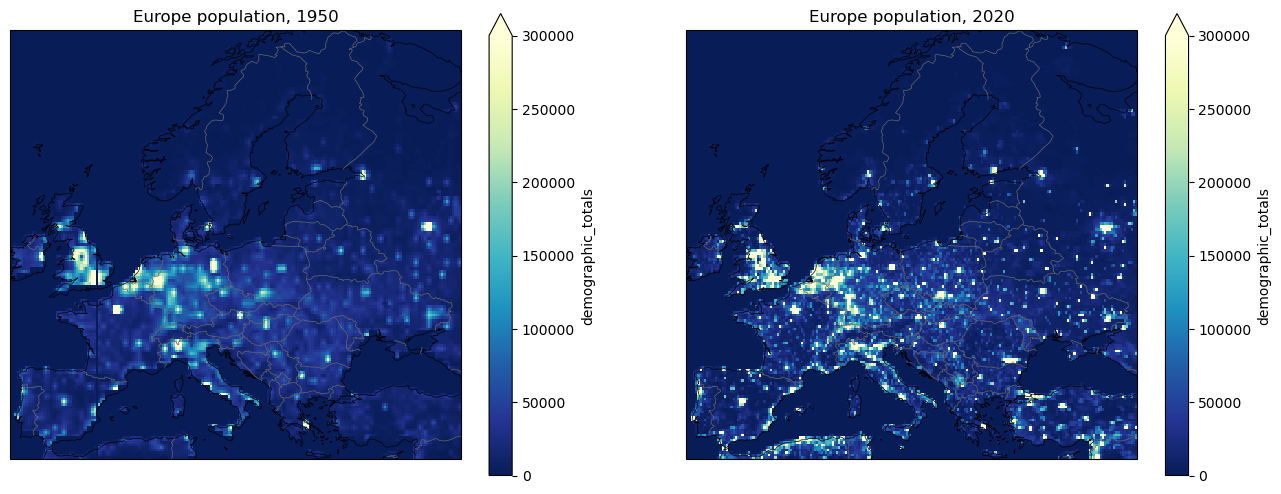

In [7]:
display.maps(
    [europe_population_1950.demographic_totals, europe_population_2020.demographic_totals],
    projection=crs.Miller(),
    cmap="YlGnBu_r",
    vmax=300_000,
    axs_set=[
        {"title": "Europe population, 1950"},
        {"title": "Europe population, 2020"},
    ],
)